<a href="https://colab.research.google.com/github/Koanah/IQTestApplication/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
#data preprocessing

from google.colab import drive
drive.mount('/content/drive')

filename = '/content/drive/My Drive/sentiment_dataset.csv'

columns = ["target", "ids", "date", "flag", "user", "text"]
data = pd.read_csv(filename, encoding="ISO-8859-1", names=columns)
print(data['target'].unique())

Mounted at /content/drive
[0 4]


In [5]:
# only keep 0 and 4 labesl
data = data[data['target'].isin([0, 4])]

#converting 4 to 1 so that 0= negative and 1= positive
data['target'] = data['target'].replace({4: 1})

print("Label distribution:")
print(data['target'].value_counts())

Label distribution:
target
0    800000
1    800000
Name: count, dtype: int64


In [6]:
# Preprocess text
def text_strip(column):
    for row in column:
        # Remove @mentions (the entire @username)
        row = re.sub(r'@\w+', ' ', str(row))

        # Existing cleaning steps
        row = re.sub("(\\t)", " ", row).lower()
        row = re.sub("(\\r)", " ", row).lower()
        row = re.sub("(\\n)", " ", row).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", row).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", row).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", row).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", row).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", row).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", row).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", row).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", row).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", row).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", row).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", row).lower()
        row = re.sub("(\-\s+)", " ", row).lower()
        row = re.sub("(\:\s+)", " ", row).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", row)
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, row)
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", row).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", row).lower()

        yield row

In [7]:
data['text'] = list(text_strip(data['text']))

In [8]:
#Lemmitization
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
w_tokenizer = WordPunctTokenizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

data['text'] = data['text'].apply(lemmatize_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
# Split dataset
X =data['text'].values
y= data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [10]:
# Tokenizer
vocab_size = 44171
oov_tok = "<OOV>"
max_len = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

# for analysing the rare words in the dataset:
thresh = 5
count= 0
total_count = 0
for key, value in tokenizer.word_counts.items():
  total_count+=1
  if value<thresh:
    count+=1

print("the percentage of rare words: ", round((count/total_count)*100,2))
print("total rare words: ", count)
print("total unique words: ", total_count)
print("vocab size excluding rare words :", total_count-count)

the percentage of rare words:  82.25
total rare words:  203372
total unique words:  247257
vocab size excluding rare words : 43885


In [11]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [18]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [19]:
# building the GRU
model = Sequential([
    Embedding(input_dim=44171, output_dim=100, input_length=200),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(GRU(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [21]:
#  Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=128,
    callbacks=[early_stop]
)
model.summary()

Epoch 1/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 489s 61ms/step - accuracy: 0.8147 - loss: 0.4074 - val_accuracy: 0.8239 - val_loss: 0.3895
Epoch 2/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 541s 66ms/step - accuracy: 0.8403 - loss: 0.3606 - val_accuracy: 0.8279 - val_loss: 0.3868
Epoch 3/5
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 547s 68ms/step - accuracy: 0.8579 - loss: 0.3270 - val_accuracy: 0.8259 - val_loss: 0.3995


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (128, 200, 100)        │     4,417,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (128, 200, 256)        │       176,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (128, 200, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (128, 128)             │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (128, 128)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (128, 64)              │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (128, 1)               │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,177,129 (54.08 MB)

 Trainable params: 4,725,709 (18.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,451,420 (36.05 MB)

In [22]:
# model evaluation
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.4f}")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 133s 13ms/step - accuracy: 0.8268 - loss: 0.3872
Test Accuracy: 0.8263


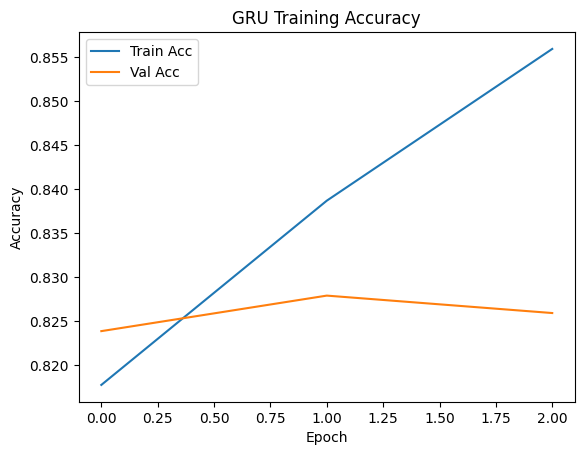

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("GRU Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
